In [1]:
import SimpleITK as sitk
import numpy as np
import sigpy as sp
from sigpy import plot
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from scipy.interpolate import griddata
import sigpy.mri

sitk_t1 = sitk.ReadImage('t1.nii.gz') 
t1 = sitk.GetArrayFromImage(sitk_t1)
t1_slice=t1[0,0,45,:,:]

print(t1.shape)
print(t1_slice.shape)

(2, 1, 90, 256, 256)
(256, 256)


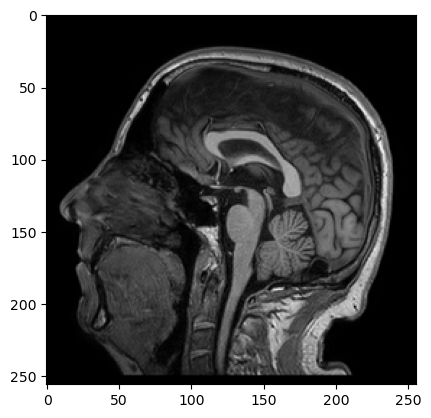

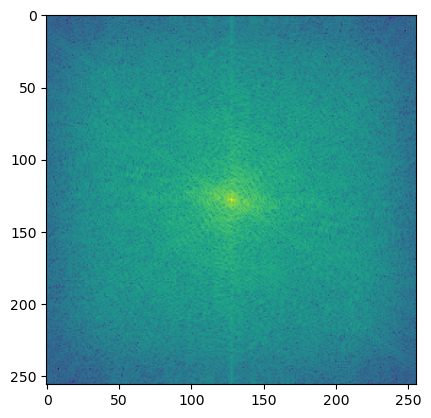

In [2]:
plt.figure()
plt.imshow(t1_slice, cmap='gray')
plt.show()

fft_t1_slice = sp.fft(t1_slice, center=True)
plt.figure()
plt.imshow(np.log10(abs(fft_t1_slice)))
plt.show()


# 1. Simulation of radial sampling: (15%)

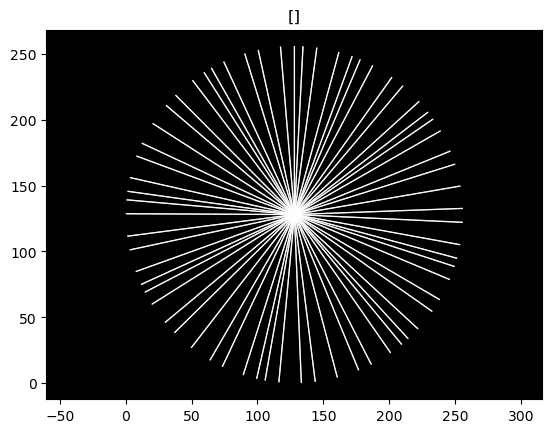

In [3]:
spikes = 64
coord = sp.mri.radial((spikes,255,2),(256,256)) + 256/2 # shift coordinates to have only positive coordinates

# show spikes used for radial sampling
sp.plot.ScatterPlot(coord)

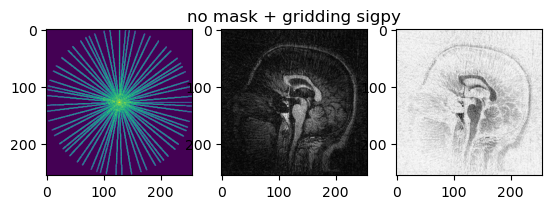

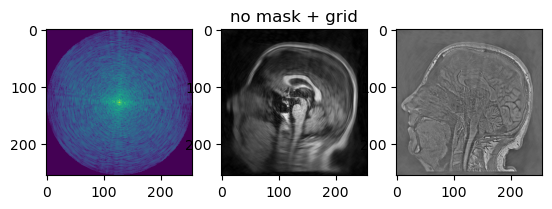

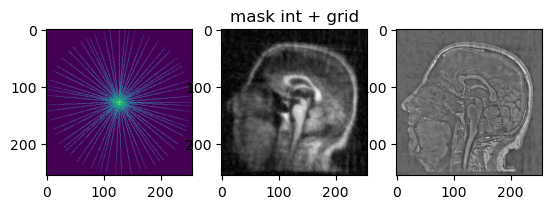

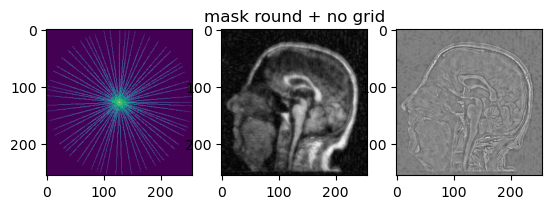

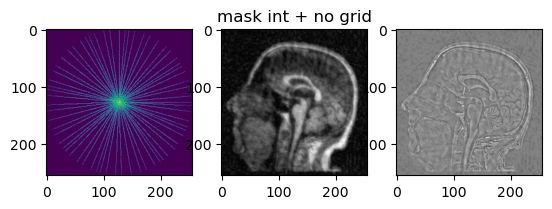

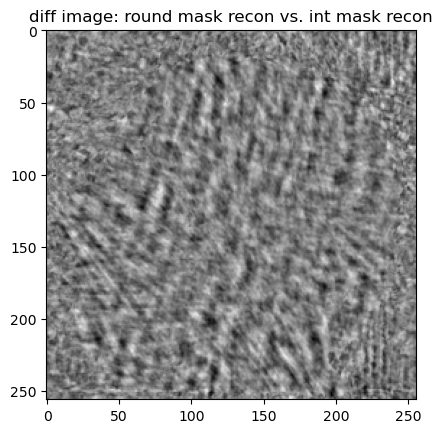

In [4]:
## Griddata with masking

# radial sampling of the original k-space
k_sp_radial = sp.interpolate(fft_t1_slice, coord)

## Setting a radial coord mask
# mask cast to int without rounding
mask = np.zeros((256, 256))
new_coord = np.array(coord, dtype=int)
mask[new_coord[:,:,0], new_coord[:,:,1]] = 1
masked_vals= fft_t1_slice*mask
inv_mask = (mask == 0)

# mask with rounded values and then cast to int
coord_round = (coord).round()
coord_round = np.array(coord_round, dtype=int)
mask_round = np.zeros((256, 256))
mask_round[coord_round[:, :, 0].flatten(), coord_round[:, :, 1].flatten()] = 1

# setting new grid for interpolation:
grid_x,grid_y = np.mgrid[0:256, 0:256]

# interpolation of sampled points to new grid using scipy griddata
points = np.transpose(np.array([coord[:, :, 0].flatten(), coord[:, :, 1].flatten()]))
values = (k_sp_radial).flatten()
t1_img_ksp = griddata(points, values, (grid_x, grid_y), method='linear', fill_value=0)

# interpolation of sampled points to a grid using sigpy gridding
coord_sigpy = sp.mri.radial((spikes,255,2),(256,256))
dcf = (coord_sigpy[..., 0]**2 + coord_sigpy[..., 1]**2)**0.5
grd = sp.gridding(k_sp_radial*dcf, coord_sigpy, shape=(256,256), kernel='spline')

# reconstruct image using inverse fourier transform
t1_recon_sigpy = sp.ifft(grd, center=True)
t1_recon_grid = sp.ifft(t1_img_ksp, center=True) # reconstruction without mask with interpolated grid
t1_recon_grid_mask = sp.ifft(t1_img_ksp * mask, center=True) # reconstruction with mask (int) with interpolated grid
t1_recon_mask_round = sp.ifft(fft_t1_slice * mask_round, center=True) # reconstruction without grid, with rounded mask values
t1_recon_mask = sp.ifft(fft_t1_slice * mask, center=True) # reconstruction without grid with mask cast to int

# plot k-space, reconstruction and difference to original image:

plt.figure()
plt.subplot(131)
plt.imshow(np.fft.fftshift(np.log10(abs(grd)+1)))
plt.subplot(132)
plt.imshow(abs(t1_recon_sigpy), cmap='gray')
plt.title('no mask + gridding sigpy')
plt.subplot(133)
plt.imshow(-abs(t1_recon_sigpy)+abs(t1_slice), cmap='gray')
plt.show()

plt.figure()
plt.subplot(131)
plt.imshow(np.log10(abs(t1_img_ksp)+1))
plt.subplot(132)
plt.imshow(abs(t1_recon_grid), cmap='gray')
plt.title('no mask + grid')
plt.subplot(133)
plt.imshow(-abs(t1_recon_grid)+abs(t1_slice), cmap='gray')
plt.show()

plt.figure()
plt.subplot(131)
plt.imshow(np.log10(abs(t1_img_ksp*mask)+1))
plt.subplot(132)
plt.imshow(abs(t1_recon_grid_mask), cmap='gray')
plt.title('mask int + grid')
plt.subplot(133)
plt.imshow(-abs(t1_recon_grid_mask)+abs(t1_slice), cmap='gray')
plt.show()

plt.figure()
plt.subplot(131)
plt.imshow(np.log10(abs(fft_t1_slice * mask_round) + 1))
plt.subplot(132)
plt.imshow(abs(t1_recon_mask_round), cmap='gray')
plt.title('mask round + no grid')
plt.subplot(133)
plt.imshow(-abs(t1_recon_mask_round)+abs(t1_slice), cmap='gray')
plt.show()

plt.figure()
plt.subplot(131)
plt.imshow(np.log10(abs(fft_t1_slice*mask)+1))
plt.subplot(132)
plt.imshow(abs(t1_recon_mask), cmap='gray')
plt.title('mask int + no grid')
plt.subplot(133)
plt.imshow(-abs(t1_recon_mask)+abs(t1_slice), cmap='gray')
plt.show()

plt.figure()
plt.imshow(-abs(t1_recon_mask)+abs(t1_recon_mask_round), cmap='gray')
plt.title('diff image: round mask recon vs. int mask recon')
plt.show()

After comparing different reconstruction methods we have decided to use the one where we apply a radial sampling mask with rounded coordinate values to the previously calculated fft image. The approach where grid interpolation was used resulted in unsatisfying and bad reconstruction.

Acceleration factor:  1.0


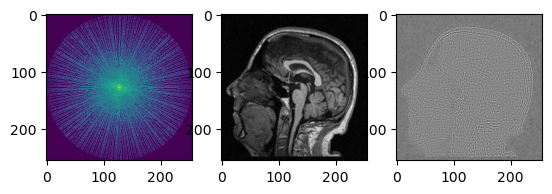

Acceleration factor:  2.0


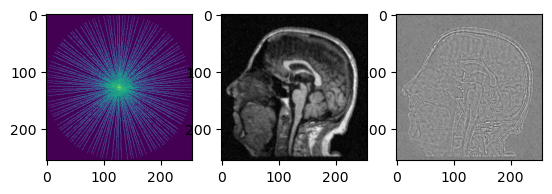

Acceleration factor:  4.0


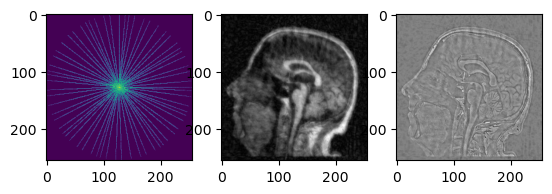

Acceleration factor:  9.846153846153847


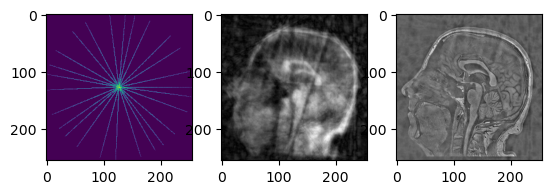

In [5]:
# compute acceleration factor:
# acceleration factor is number of sample points with cartesian sampling divided by number of sampling points with radial points:
# acc = (256*256)/(n_spikes*samples_per_spikes) -> with samples_per_spikes=256:  n_spikes = 256/acc
# acc in [1, 10]: upper boundary: n_spikes >= 256/10 = 25.6; lower boundary: n_spikes <= 256/1 = 256
# --> Values for spikes between 26 and 156 spikes are permissible

n_spikes = [256, 128, 64, 26] # list of number of spikes

ffts = [] # list to store ffts
iffts = [] # list to store subsampled images


for n in n_spikes:
    tmp_coord = sp.mri.radial((n,256,2), (256,256)) + 255/2
    tmp_coord_round = (tmp_coord).round()
    tmp_coord_round = np.array(tmp_coord_round, dtype=int)
    tmp_mask_round = np.zeros((256, 256))
    tmp_mask_round[tmp_coord_round[:, :, 0].flatten(), tmp_coord_round[:, :, 1].flatten()] = 1

    # append to list for further analysis
    ffts.append(fft_t1_slice * tmp_mask_round)
    iffts.append(abs(sp.ifft(fft_t1_slice * tmp_mask_round, center=True)))

# plot all ffts and respective iffts
for n, fft, ifft in zip(n_spikes, ffts, iffts):
    print("Acceleration factor: ", 256/n)
    plt.figure()
    plt.subplot(131)
    plt.imshow(np.log10(abs(fft)+1))
    plt.subplot(132)
    plt.imshow(ifft, cmap='gray')
    plt.subplot(133)
    plt.imshow(t1_slice-ifft, cmap='gray')
    plt.show()


## Task 2: Quality assessment (10%)

In [6]:
metrics = np.zeros((len(n_spikes), 2))
for i in range(len(n_spikes)):
    metrics[i][0] = peak_signal_noise_ratio(t1_slice, iffts[i], data_range=(t1_slice.max() - t1_slice.min()))
    metrics[i][1] = structural_similarity(t1_slice, iffts[i], data_range=(t1_slice.max() - t1_slice.min()))
    print("n_spikes: ", n_spikes[i], " ,Acceleration:", 256/n_spikes[i])
    print("PSNR: ", metrics[i][0])
    print("SSIM: ", metrics[i][1])
    print("  ")


n_spikes:  256  ,Acceleration: 1.0
PSNR:  32.12065051199333
SSIM:  0.7259091734394699
  
n_spikes:  128  ,Acceleration: 2.0
PSNR:  27.27986838758634
SSIM:  0.6098655805530516
  
n_spikes:  64  ,Acceleration: 4.0
PSNR:  23.746072941239174
SSIM:  0.4744852941715772
  
n_spikes:  26  ,Acceleration: 9.846153846153847
PSNR:  20.4348145890166
SSIM:  0.31973645596219885
  


# Task 3: Reconstruction with the non-uniform Fourier transform (NUFT): (30%)

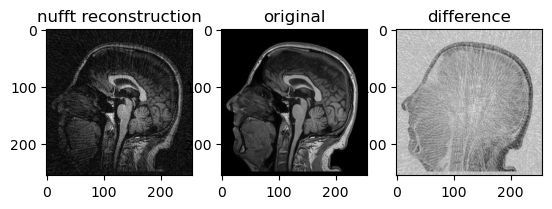

Max value nufft reconstruction:  18527.58331463818
Max value original image:  549


In [7]:
spikes = 128

fft_t1_slice = sp.fft(t1_slice, center=True)
coord_nufft = sp.mri.radial((spikes,255,2), (256,256))
ksp_nufft = sp.interpolate(fft_t1_slice, coord_nufft + 256/2)

# density compensated function
dcf_nufft = (coord_nufft[..., 0]**2 + coord_nufft[..., 1]**2)**0.5

t1_recon_nufft = sp.nufft_adjoint(ksp_nufft * dcf_nufft, coord_nufft, oshape=(256, 256))

# Plotting reconstruction and compare it to original image
plt.figure()
plt.subplot(131)
plt.title("nufft reconstruction")
plt.imshow(abs(t1_recon_nufft), cmap="gray")
plt.subplot(132)
plt.title("original")
plt.imshow( t1_slice, cmap="gray")
plt.subplot(133)
plt.title("difference")
# normalize values to get a meaningful difference for visual inspection
plt.imshow( ((abs(t1_recon_nufft))/abs(t1_recon_nufft).max()) - t1_slice/t1_slice.max(), cmap="gray")
plt.show()

# print maximum values of images
print("Max value nufft reconstruction: ", abs(t1_recon_nufft).max())
print("Max value original image: ", t1_slice.max())

After performing nufft using sigpy we notice the change in the magnitude of the intensity values what makes it hard to visually compare the quality of the reconstruction. The intensity values increase with the increasing number of spikes.

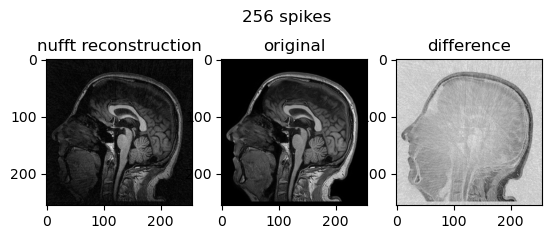

Max value nufft reconstruction:  38604.74899809367
Max value original image:  549


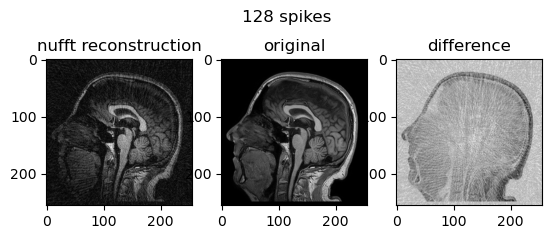

Max value nufft reconstruction:  18527.58331463818
Max value original image:  549


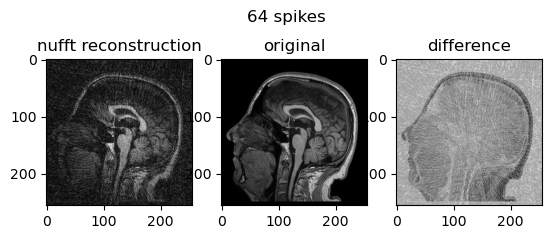

Max value nufft reconstruction:  9611.039960796656
Max value original image:  549


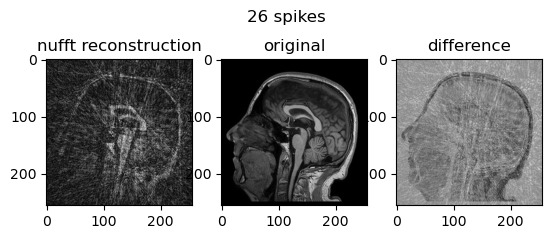

Max value nufft reconstruction:  4725.9239766494
Max value original image:  549


In [8]:
n_spikes = [256, 128, 64, 26] # list of number of spikes
nuffts = [] # list to store ffts
nuiffts = [] # list to store subsampled images
fft_t1_slice = sp.fft(t1_slice, center=True)

for i in n_spikes:
    coord_nufft = sp.mri.radial((i,255,2), (256,256))
    ksp_nufft = sp.interpolate(fft_t1_slice, coord_nufft + 256/2)

    # density compensated function
    dcf_nufft = (coord_nufft[..., 0]**2 + coord_nufft[..., 1]**2)**0.5
    t1_recon_nufft = sp.nufft_adjoint(ksp_nufft * dcf_nufft, coord_nufft, oshape=(256, 256))
    nuffts.append(dcf_nufft)
    nuiffts.append(abs(t1_recon_nufft))

for k in range(len(n_spikes)):
    # Plotting reconstruction and compare it to original image
    plt.figure()
    plt.suptitle('{} spikes'.format(n_spikes[k]), y=0.75)
    plt.subplot(131)
    plt.title("nufft reconstruction")
    plt.imshow(nuiffts[k], cmap="gray")
    plt.subplot(132)
    plt.title("original")
    plt.imshow(t1_slice, cmap="gray")
    plt.subplot(133)
    plt.title("difference")
    # normalize values to get a meaningful difference for visual inspection
    plt.imshow( nuiffts[k]/(nuiffts[k].max()) - t1_slice/t1_slice.max(), cmap="gray")
    plt.show()

    # print maximum values of images
    print("Max value nufft reconstruction: ", nuiffts[k].max())
    print("Max value original image: ", t1_slice.max())

# 4. Other reconstruction methods: (20%)

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

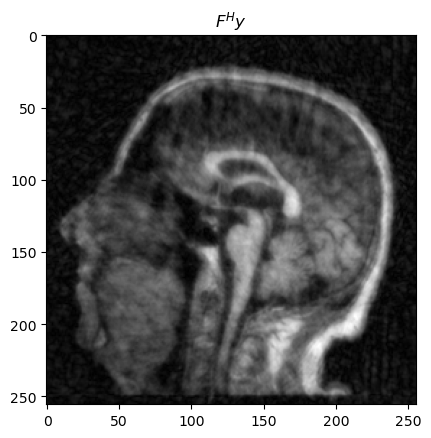

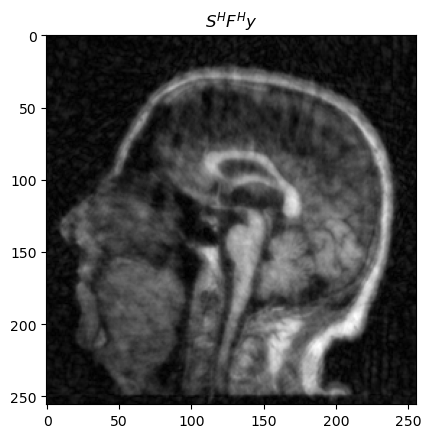

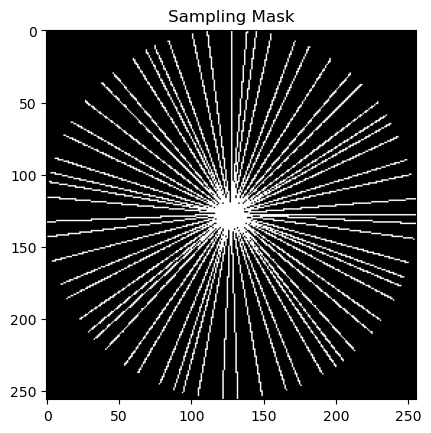

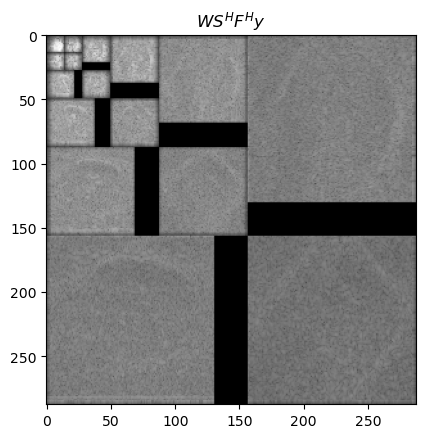

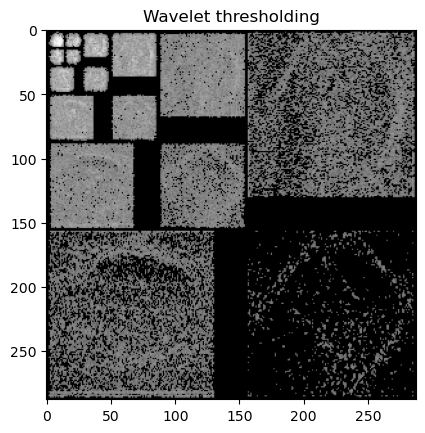

In [85]:
spikes = 64

fft_t1_slice = sp.fft(t1_slice, center=True)
coord_wl = sp.mri.radial((spikes,255,2), (256,256)) + 255/2
# mask with rounded values and then cast to int
coord_round_wl = (coord_wl).round()
coord_round_wl = np.array(coord_round_wl, dtype=int)
mask_round_wl = np.zeros((256, 256))
mask_round_wl[coord_round_wl[:, :, 0].flatten(), coord_round_wl[:, :, 1].flatten()] = 1
ksp_wavelet = fft_t1_slice * mask_round_wl
# since we only have one coil, expand dimension, so that first index is the coil index
ksp_wavelet = np.expand_dims(ksp_wavelet, axis=0)

# Defining Linear Operators
F = sp.linop.FFT(ksp_wavelet.shape, axes=None)

# test Operator F
plt.figure()
plt.title(r'$F^H y$')
plt.imshow(abs(F.H * ksp_wavelet)[0], cmap="gray")

# define S
# get estimate of sensitivity map
mps = sp.mri.app.EspiritCalib(ksp=ksp_wavelet).run()
S = sp.linop.Multiply(ksp_wavelet.shape, mps)

# test Operator S
plt.figure()
plt.title(r'$S^H F^H y$')
plt.imshow(abs(S.H * F.H * ksp_wavelet)[0], cmap="gray")

# define P: Sampling operator
mask_round_wl = np.expand_dims(mask_round_wl, axis=0)
P = sp.linop.Multiply(ksp_wavelet.shape, mask_round_wl)
# test operator
plt.figure()
plt.title("Sampling Mask")
plt.imshow(mask_round_wl[0], cmap="gray")

# define W: Wavelet Transform Operator
W = sp.linop.Wavelet(ksp_wavelet.shape, axes=(1, 2))
wav = W * S.H * F.H * ksp_wavelet

# test operator wav
plt.figure()
plt.title(r'$W S^H F^H y$')
plt.imshow(abs(wav**0.1)[1], cmap="gray")

# define forward operator:
A = P * F * S * W.H

# define proximal operator and apply it to the wavelet coefficients
lamda = 5
proxg = sp.prox.L1Reg(wav.shape, lamda)
alpha = 1
wav_thresh = proxg(alpha, wav)

plt.figure()
plt.title("Wavelet thresholding")
plt.imshow(abs(wav_thresh**0.1)[1], cmap="gray")



/var/folders/fd/ymx2k4796fj6r_mr01xt94br0000gn/T/ipykernel_52100/3120971581.py:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  wav_hat = np.zeros(wav.shape, np.complex)


L1WaveletRecon, Iteration=100

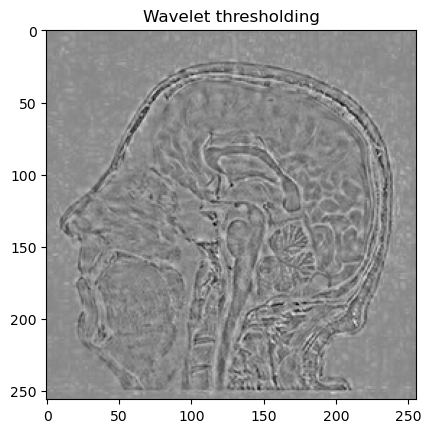

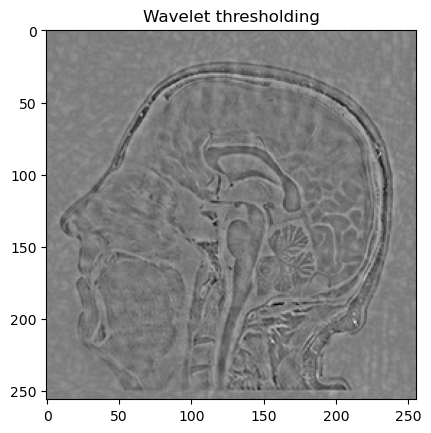

In [88]:
max_iter = 100
alpha = 1

def gradf(x):
    return A.H * (A * x - ksp_wavelet)

wav_hat = np.zeros(wav.shape, np.complex)
alg = sp.alg.GradientMethod(gradf, wav_hat, alpha, proxg=proxg, max_iter=max_iter)

while not alg.done():
    alg.update()
    print('\rL1WaveletRecon, Iteration={}'.format(alg.iter), end='')

plt.figure()
plt.title("Wavelet thresholding")
plt.imshow(abs(W.H(wav_hat))[0] - t1_slice, cmap="gray")
plt.figure()
plt.title("Wavelet thresholding")
plt.imshow(abs(F.H * ksp_wavelet)[0] - t1_slice, cmap="gray")
#plot.ImagePlot(W.H(wav_hat))

## Wrapping Operators in an app

In [62]:
class L1WaveletRecon(sp.app.App):
    def __init__(self, ksp, mask, mps, lamda, max_iter):
        img_shape = mps.shape[1:]

        S = sp.linop.Multiply(img_shape, mps)
        F = sp.linop.FFT(ksp.shape, axes=(-1, -2))
        P = sp.linop.Multiply(ksp.shape, mask)
        self.W = sp.linop.Wavelet(img_shape)
        A = P * F * S * self.W.H

        proxg = sp.prox.L1Reg(A.ishape, lamda)

        self.wav = np.zeros(A.ishape, np.complex)
        alpha = 1
        def gradf(x):
            return A.H * (A * x - ksp)

        alg = sp.alg.GradientMethod(gradf, self.wav, alpha, proxg=proxg,
                                    max_iter=max_iter)
        super().__init__(alg)

    def _output(self):
        return self.W.H(self.wav)